In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
plt.rcParams.update({'font.size': 16}) # Gir større skrift på figurer

# a)
Leser inn data

In [2]:
df = pd.read_csv("../data/compas-scores-two-years.csv")
df = df[df["days_b_screening_arrest"] <= 30]
df = df[df["days_b_screening_arrest"] >= -30]
df.drop([
    "id",
    "name",
    "first",
    "last",
    "dob",
    "violent_recid",
    "decile_score.1"
], axis=1, inplace=True)

df["binary_approximation"] = df["score_text"].apply(lambda x: 0 if x == "Low" else 1)

Finner ut hvilke desiler som tilsvarer hvilke tekst-scores

In [3]:
temp_df = df.where(df["score_text"] == "Low")
temp_df.dropna(subset="decile_score", inplace=True)
print(temp_df["score_text"].unique())
print(sorted(temp_df["decile_score"].unique()))

['Low']
[1.0, 2.0, 3.0, 4.0]


In [4]:
temp_df = df.where(df["score_text"] == "Medium")
temp_df.dropna(subset="decile_score", inplace=True)
print(temp_df["score_text"].unique())
print(sorted(temp_df["decile_score"].unique()))

['Medium']
[5.0, 6.0, 7.0]


In [5]:
temp_df = df.where(df["score_text"] == "High")
temp_df.dropna(subset="decile_score", inplace=True)
print(temp_df["score_text"].unique())
print(sorted(temp_df["decile_score"].unique()))

['High']
[8.0, 9.0, 10.0]


hvor ofte ulike grupperinger av mennesker (kvinner, menn, hvite og svarte) gjentar forbrytelser og blir predikert, av algoritmen, til å begå straffbare handlinger i framtiden (som andel, ikke totalt antall).

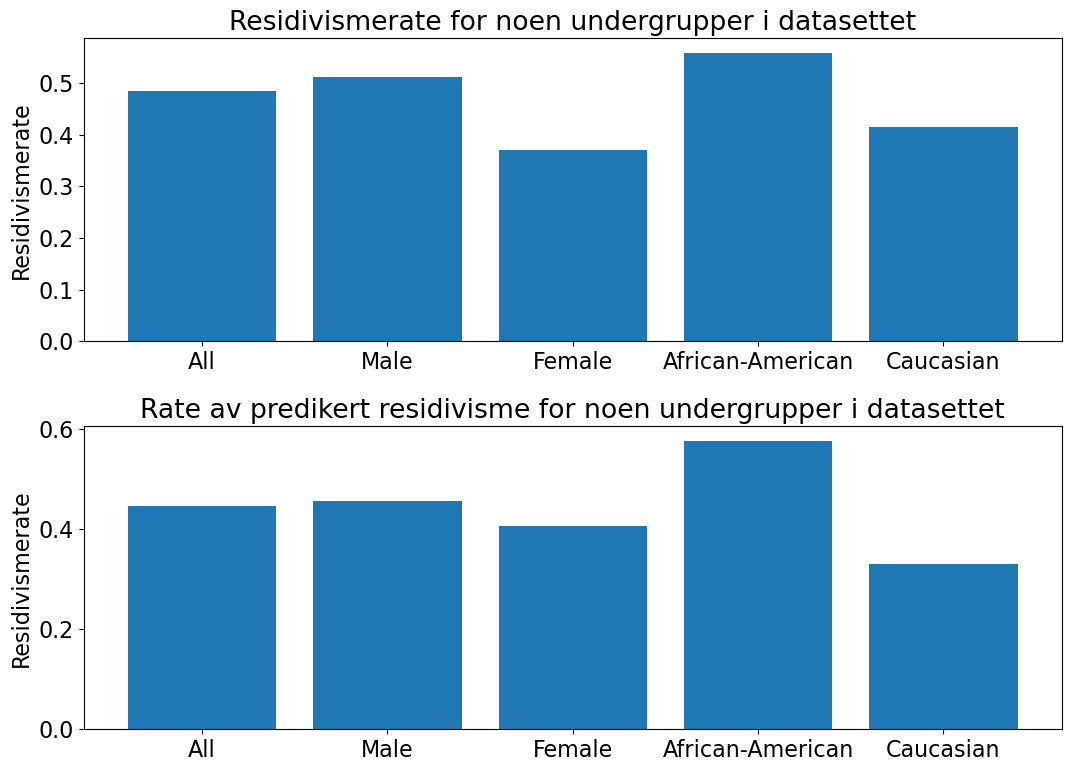

In [6]:
recid = dict()
pred = dict()

kolonner = ["sex", "sex", "race", "race"]
grupper = ["Male", "Female", "African-American", "Caucasian"]

recid["All"] = np.mean(df["is_recid"])
pred["All"] = np.mean(df["binary_approximation"])

for k, g in zip(kolonner, grupper):
    temp_df = df.where(df[k] == g)
    recid[g] = np.mean(temp_df["is_recid"])
    pred[g] = np.mean(temp_df["binary_approximation"])

fig = plt.figure(figsize=(11, 8))
ax = list()
ax.append(fig.add_subplot(211))
ax.append(fig.add_subplot(212))

ax[0].bar(recid.keys(), recid.values())
ax[0].set_ylabel("Residivismerate")
ax[0].set_title("Residivismerate for noen undergrupper i datasettet")
ax[1].bar(pred.keys(), pred.values())
ax[1].set_ylabel("Residivismerate")
ax[1].set_title("Rate av predikert residivisme for noen undergrupper i datasettet")
plt.tight_layout()

Hvor ofte ulike grupper fikk ulike risiko-scorer

In [7]:
def histogram(temp_df, kolonne, gruppe, title_supp=""):
    fig, ax = plt.subplots(1, 2)

    if kolonne is not None and gruppe is not None:
        temp_df = df.where(df[kolonne] == gruppe)
        temp_df.dropna(subset=kolonne, inplace=True)
        fig.suptitle("Predikert for " + kolonne + ": " + gruppe + title_supp)
    else:
        fig.suptitle("Predikert for " + title_supp)

    h = np.histogram(temp_df["decile_score"], bins=np.arange(0.5, 11, 1))[0]
    h = np.asarray(h, dtype=float)
    h /= h.sum()
    ax[0].bar(np.arange(1, 11, 1), h)

    keys = ["Low", "Medium", "High"]
    counts = temp_df["score_text"].value_counts()[keys].to_numpy(dtype=float)
    counts /= counts.sum()
    ax[1].bar(keys, counts)

    ax[0].set_xlabel("Desil score")
    ax[1].set_xlabel("Score tekst")
    ax[0].set_ylabel("Andel av gruppen")
    ax[1].set_ylabel("Andel av gruppen")

    fig.set_size_inches(10,5)

    plt.tight_layout()

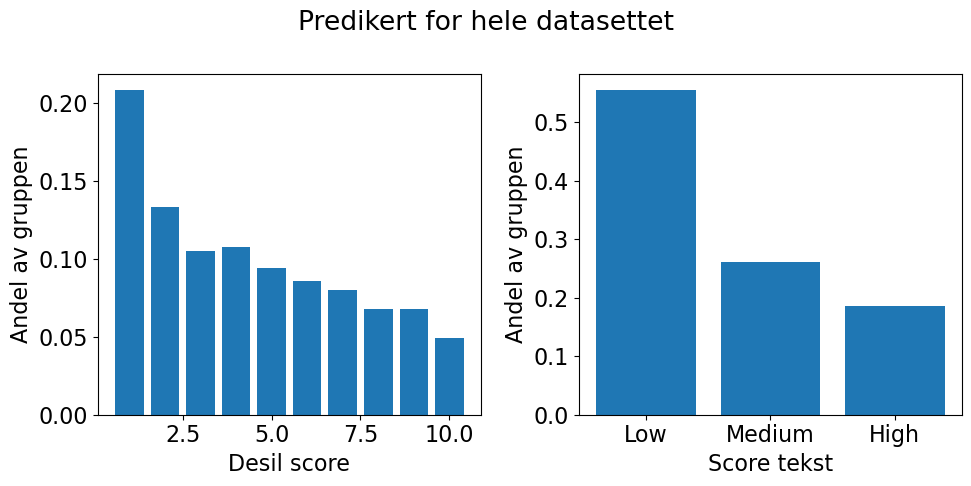

In [8]:
histogram(df, None, None, title_supp="hele datasettet")

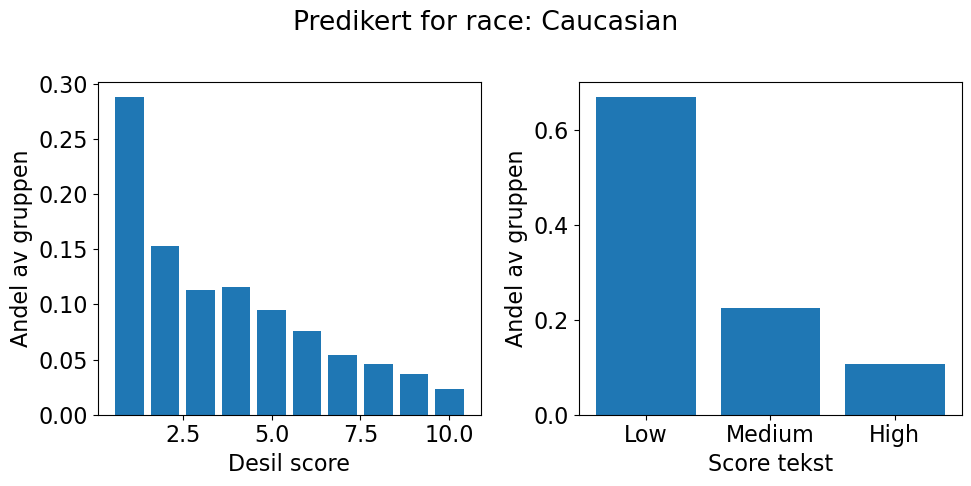

In [9]:
histogram(df, "race", "Caucasian")

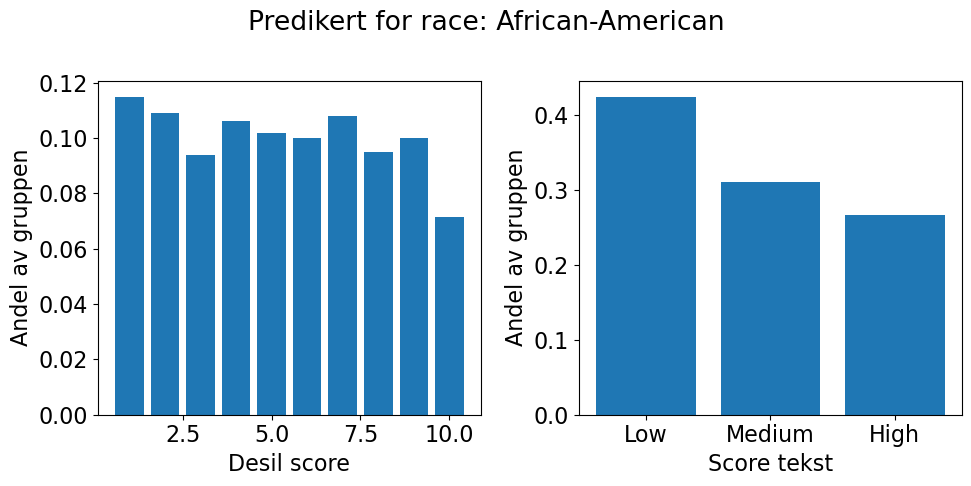

In [10]:
histogram(df, "race", "African-American")

hvor ofte de som begikk nye straffbare hadlinger (og de som ikke gjorde det) fikk ulike risikoskårer, og hvordan dette ser ut hvis du kun ser på hvite eller svarte.

In [11]:
temp_df = df.where(df["is_recid"] == 1)

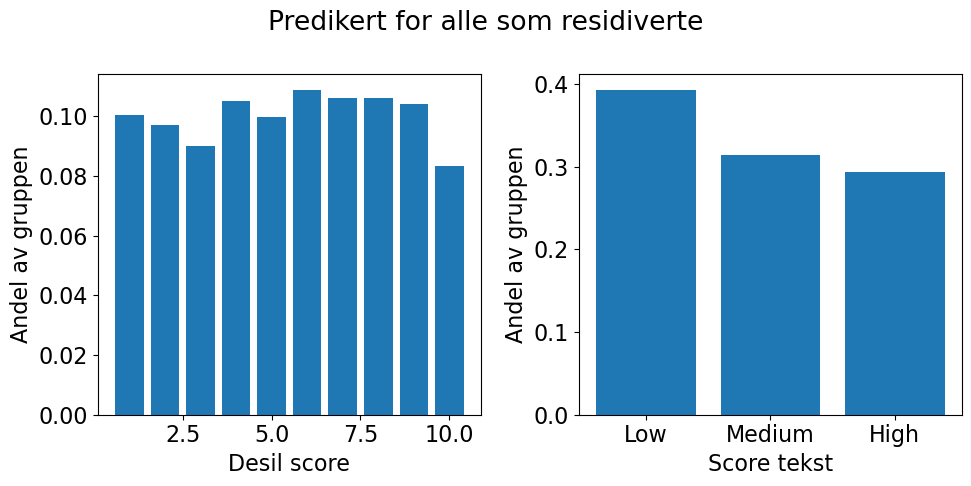

In [12]:
histogram(temp_df, None, None, title_supp="alle som residiverte")

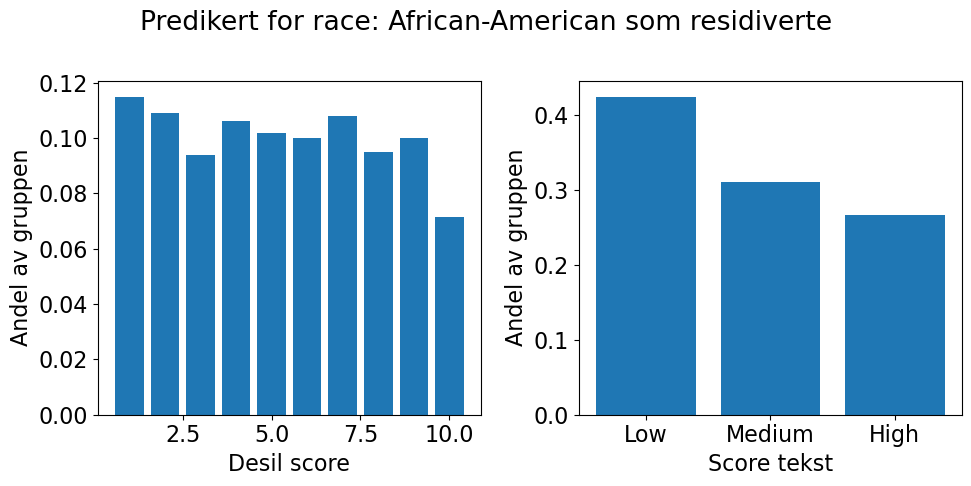

In [13]:
histogram(temp_df, "race", "African-American", title_supp=" som residiverte")

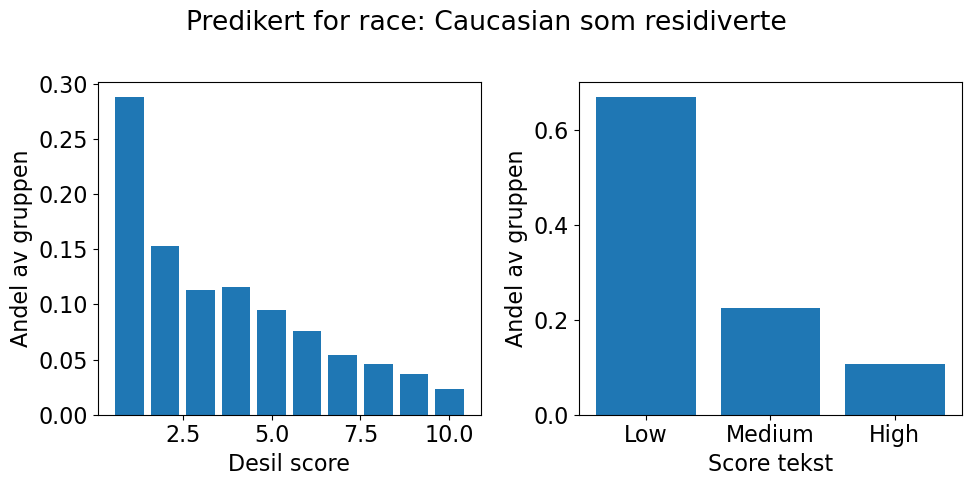

In [14]:
histogram(temp_df, "race", "Caucasian", title_supp=" som residiverte")

In [15]:
temp_df = df.where(df["is_recid"] == 0)

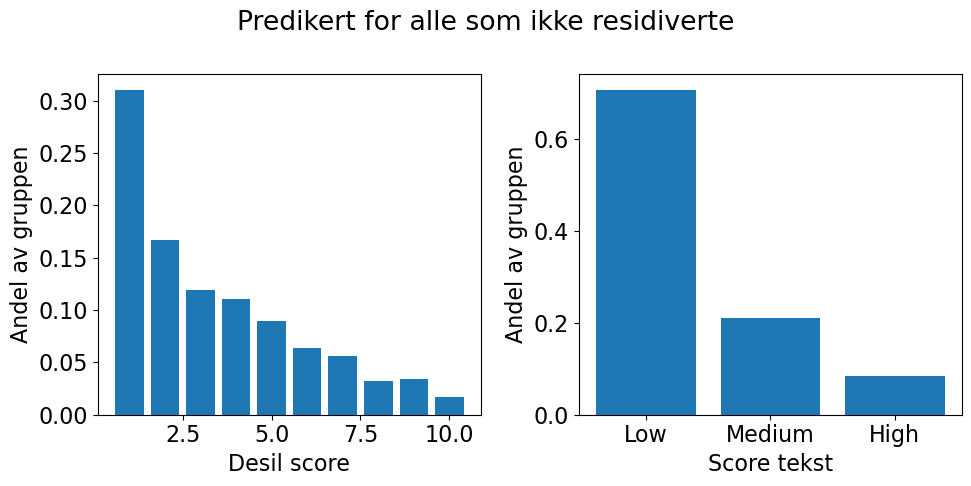

In [16]:
histogram(temp_df, None, None, title_supp="alle som ikke residiverte")

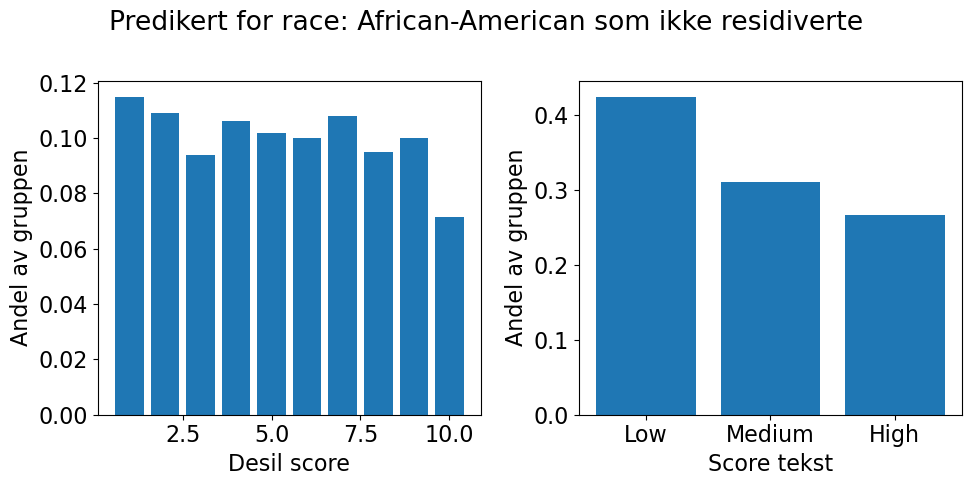

In [17]:
histogram(temp_df, "race", "African-American", title_supp=" som ikke residiverte")

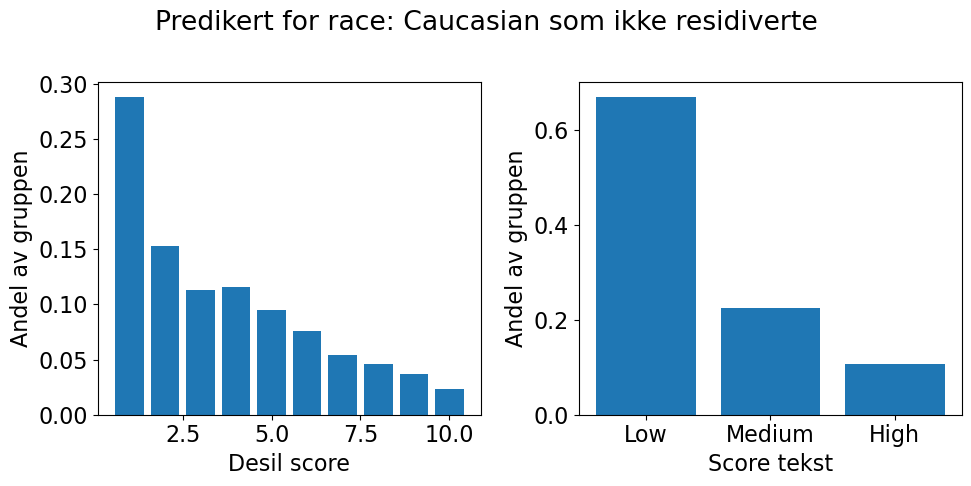

In [18]:
histogram(temp_df, "race", "Caucasian", title_supp=" som ikke residiverte")

# b)

In [19]:
def drop_all_except(dataframe, to_keep, inplace=True):
    """fjerner alle kolonnene fra dataframe bortsett fra de i listen/arrayet to_keep"""
    # liste med alle kolonnene
    to_drop = list(df.columns.to_numpy())

    for keep in to_keep:
        to_drop.remove(keep)
    
    return dataframe.drop(to_drop, inplace=inplace, axis=1)

In [20]:
def truth_table(kolonne, gruppe, pred="binary_approximation"):
    # lager en dataframe med kun de relevante kolonnene
    copy_df = df.copy()
    drop_all_except(copy_df, ["sex", "race", pred, "is_recid"])
    copy_df.dropna(subset=pred, inplace=True)

    # henter ut den ønskede gruppen
    if kolonne is not None and gruppe is not None:
        copy_df = copy_df.where(df[kolonne] == gruppe)
        copy_df.dropna(subset=kolonne, inplace=True)

    actual = copy_df["is_recid"].to_numpy()
    prediction = copy_df[pred].to_numpy()

    true_positives = np.logical_and(actual, prediction).mean()
    false_positives = np.logical_and(actual == 0, prediction).mean()
    true_negatives = np.logical_and(actual == 0, prediction == 0).mean()
    false_negatives = np.logical_and(actual, prediction == 0).mean()

    # lager og printer tabell
    table = list()

    if kolonne is not None and gruppe is not None:
        table.append([f"{kolonne}: {gruppe}", "Actual true", "Actual false"])
    else:
        table.append(["All", "Actual true", "Actual false"])

    table.append(["Predicted true", true_positives, false_positives])
    table.append(["Predicted false", false_negatives, true_negatives])
    print(tabulate(table, tablefmt="mixed_grid"))
    print("Positiv prediktiv verdi: ", true_positives/(true_positives+false_positives))

    return table

In [21]:
tab = truth_table(None, None)

┍━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┑
│ All             │ Actual true         │ Actual false        │
├─────────────────┼─────────────────────┼─────────────────────┤
│ Predicted true  │ 0.29439403758911215 │ 0.15132858068697344 │
├─────────────────┼─────────────────────┼─────────────────────┤
│ Predicted false │ 0.19005184705119896 │ 0.3642255346727155  │
┕━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┙
Positiv prediktiv verdi:  0.6604870956015993


In [22]:
tab = truth_table("sex", "Male")

┍━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┑
│ sex: Male       │ Actual true         │ Actual false        │
├─────────────────┼─────────────────────┼─────────────────────┤
│ Predicted true  │ 0.3123874324594757  │ 0.14288573143886332 │
├─────────────────┼─────────────────────┼─────────────────────┤
│ Predicted false │ 0.19891935161096658 │ 0.34580748449069443 │
┕━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┙
Positiv prediktiv verdi:  0.6861538461538461


In [23]:
tab = truth_table("sex", "Female")

┍━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┑
│ sex: Female     │ Actual true        │ Actual false        │
├─────────────────┼────────────────────┼─────────────────────┤
│ Predicted true  │ 0.2178723404255319 │ 0.18723404255319148 │
├─────────────────┼────────────────────┼─────────────────────┤
│ Predicted false │ 0.1523404255319149 │ 0.4425531914893617  │
┕━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┙
Positiv prediktiv verdi:  0.5378151260504203


In [24]:
tab = truth_table("race", "African-American")

┍━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┑
│ race: African-American │ Actual true         │ Actual false        │
├────────────────────────┼─────────────────────┼─────────────────────┤
│ Predicted true         │ 0.39307086614173226 │ 0.18299212598425196 │
├────────────────────────┼─────────────────────┼─────────────────────┤
│ Predicted false        │ 0.16535433070866143 │ 0.2585826771653543  │
┕━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┙
Positiv prediktiv verdi:  0.6823400765445599


In [25]:
tab = truth_table("race", "Caucasian")

┍━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┑
│ race: Caucasian │ Actual true         │ Actual false        │
├─────────────────┼─────────────────────┼─────────────────────┤
│ Predicted true  │ 0.20446980504041845 │ 0.12648597242035187 │
├─────────────────┼─────────────────────┼─────────────────────┤
│ Predicted false │ 0.21112696148359486 │ 0.4579172610556348  │
┕━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┙
Positiv prediktiv verdi:  0.617816091954023


# c)

In [26]:
temp_df = df.where(df["is_recid"] == 1)
temp_df.dropna(subset="is_recid", inplace=True)
temp_df["is_recid"].unique()
P_BA = np.mean(temp_df["race"] == "African-American")
P_A = np.mean(df["is_recid"])
P_B = np.mean(df["race"] == "African-American")
temp_df = df.where(df["race"] == "African-American")
temp_df.dropna(subset="is_recid", inplace=True)
P_AB = np.mean(temp_df["is_recid"])
aa_P_AB = P_AB

print("P(B|A)", P_BA)
print("P(B)", P_B)
print("P(A)", P_A)
print("P(A|B)", P_BA*P_A/P_B)
print("P(A|B) i datasettet", P_AB)

P(B|A) 0.5929765886287626
P(B) 0.5144199611147116
P(A) 0.4844458846403111
P(A|B) 0.5584251968503938
P(A|B) i datasettet 0.5584251968503937


In [27]:
temp_df = df.where(df["is_recid"] == 1)
temp_df.dropna(subset="is_recid", inplace=True)
temp_df["is_recid"].unique()
P_BA = np.mean(temp_df["race"] == "Caucasian")
P_A = np.mean(df["is_recid"])
P_B = np.mean(df["race"] == "Caucasian")
temp_df = df.where(df["race"] == "Caucasian")
temp_df.dropna(subset="is_recid", inplace=True)
P_AB = np.mean(temp_df["is_recid"])
c_P_AB = P_AB

print("P(B|A)", P_BA)
print("P(B)", P_B)
print("P(A)", P_A)
print("P(A|B)", P_BA*P_A/P_B)
print("P(A|B) i datasettet", P_AB)

P(B|A) 0.2923076923076923
P(B) 0.34073233959818533
P(A) 0.4844458846403111
P(A|B) 0.41559676652401334
P(A|B) i datasettet 0.41559676652401334


In [28]:
print(f"Forventet forskjell i prediksjonsrate for hvite og svarte: {aa_P_AB/c_P_AB=:.3g}")

Forventet forskjell i prediksjonsrate for hvite og svarte: aa_P_AB/c_P_AB=1.34


# d)

In [29]:
from sklearn.linear_model import LogisticRegression
X = df[["age_cat", "race", "sex", "priors_count", "c_charge_degree", "two_year_recid"]]
categorical_cols = ["age_cat", "race", "sex", "c_charge_degree"]
X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')
Y = df["score_text"] != "Low"

clf = LogisticRegression(max_iter=int(1e4), tol=0)
_ = clf.fit(X, Y)
columns = np.array(X.columns)
coef = np.array(clf.coef_[0])
i = np.argsort(coef)
coef = coef[i]
columns = columns[i]
coef_aa =  coef[list(columns).index("race_African-American")]

print("Accuracy:", (clf.predict(X)==Y).mean())
print("Iterations:", clf.n_iter_)
print("African-American coefficient:", coef_aa)

Accuracy: 0.7508101101749838
Iterations: [83]
African-American coefficient: 0.48892150525827266


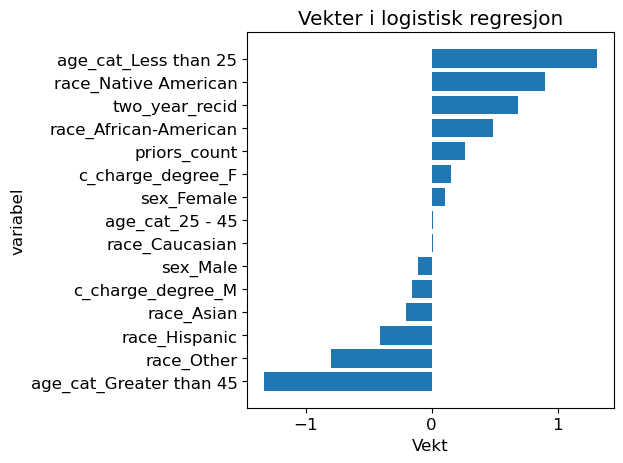

In [30]:
plt.rcParams.update({'font.size': 12}) # Gir større skrift på figurer
plt.title("Vekter i logistisk regresjon")
plt.barh(columns, coef)
plt.xlabel("Vekt")
plt.ylabel("variabel")
plt.tight_layout()
plt.rcParams.update({'font.size': 16}) # Gir større skrift på figurer

In [31]:
# gruppen ProPublica sammenlignet hvite og svarte i
kontroll = ["age_cat_25 - 45", "sex_Male", "c_charge_degree_F"]

# lager en dataframe med samme kolonner som vi trente på,
# bare at den har en rad der alle verdier tilsvarer kontrollgruppen (bortsett fra rase)
x = X.iloc[:0].copy()
x.loc[1] = 0
x[kontroll] = 1

# finner kontroll-sannsynligheten
x["race_Caucasian"] = 1
caucasian = clf.predict_proba(x)[0,1]

# endrer til afroamerikaner
x["race_African-American"] = 1
x["race_Caucasian"] = 0

# finner hvor mye mer sannsynlig det er at en afroamerikaner blir predikert ikke-lav risiko.
african_american = clf.predict_proba(x)[0,1]
racialBias = african_american/caucasian
print(f"{african_american=:.4g},{caucasian=:.4g},{african_american/caucasian=:.4g}")

african_american=0.2601,caucasian=0.179,african_american/caucasian=1.453


# Litt mer interessante resultater (utenfor oppgavetekst)
Først tester jeg ut litt forskjellige grupper å sammenligne hvite og svarte i og ser på hva som gir hvilke resultater

In [32]:
print(X.columns)

Index(['priors_count', 'two_year_recid', 'age_cat_25 - 45',
       'age_cat_Greater than 45', 'age_cat_Less than 25',
       'race_African-American', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native American', 'race_Other', 'sex_Female',
       'sex_Male', 'c_charge_degree_F', 'c_charge_degree_M'],
      dtype='object')


In [33]:
# lager en dataframe med samme kolonner som vi trente på,
# finner en spennende gruppe å se på :)
x = X.iloc[:0].copy()
x.loc[1] = 0
booleans_til_true = ["age_cat_Less than 25", "sex_Male", "c_charge_degree_F"]
x[booleans_til_true] = 1
x["priors_count"] = np.mean(df["priors_count"])*2
print("Endret her kun priors_count til:")
print(f"Gjennomsnittlig priors_count i datasettet: {np.mean(df["priors_count"]):.3g}, brukte her det dobbelte av dette (som er like langt unna gjennomsnittet som 0 brukt av ProPublica)")

# finner kontroll-sannsynligheten
x["race_Caucasian"] = 1
caucasian = clf.predict_proba(x)[0,1]

# endrer til afroamerikaner
x["race_African-American"] = 1
x["race_Caucasian"] = 0

# finner hvor mye mer sannsynlig det er at en afroamerikaner blir predikert ikke-lav risiko.
african_american = clf.predict_proba(x)[0,1]
racialBias = african_american/caucasian
print(f"{african_american=:.3g},{caucasian=:.3g},{african_american/caucasian=:.3g}")

Endret her kun priors_count til:
Gjennomsnittlig priors_count i datasettet: 3.25, brukte her det dobbelte av dette (som er like langt unna gjennomsnittet som 0 brukt av ProPublica)
african_american=0.881,caucasian=0.821,african_american/caucasian=1.07


In [34]:
# lager en dataframe med samme kolonner som vi trente på,
# finner en spennende gruppe å se på :)
x = X.iloc[:0].copy()
x.loc[1] = 0
booleans_til_true = ["age_cat_Greater than 45", "sex_Male", "c_charge_degree_F"]
x[booleans_til_true] = 1


# finner kontroll-sannsynligheten
x["race_Caucasian"] = 1
caucasian = clf.predict_proba(x)[0,1]

# endrer til afroamerikaner
x["race_African-American"] = 1
x["race_Caucasian"] = 0

# finner hvor mye mer sannsynlig det er at en afroamerikaner blir predikert ikke-lav risiko.
african_american = clf.predict_proba(x)[0,1]
racialBias = african_american/caucasian
print("Endret kun alderskategori til større enn 45 og fikk")
print(f"{african_american=:.3g},{caucasian=:.3g},{african_american/caucasian=:.3g}")

Endret kun alderskategori til større enn 45 og fikk
african_american=0.0839,caucasian=0.0537,african_american/caucasian=1.56


Ser at når det er høye risikoer for begge raser, er det liten relativ forskjell og når det er lave risikoer er det stor relativ forskjell. Dette tyder på at ProPublica fikk en stor forskjell siden de kun sammenlignet for null tidligere arrester. Hvor stor forskjell kan man da forvente å få for den "gjennomsnittlige" arresterte?

Bytter da til alder i steden for alderskategori siden en da kan finne gjennomsnittet og det blir bedre oppløsning.

In [35]:
X = df[["age", "race", "sex", "priors_count", "c_charge_degree", "two_year_recid"]]
categorical_cols = ["race", "sex", "c_charge_degree"]
X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')
Y = df["score_text"] != "Low"

clf = LogisticRegression(max_iter=int(1e4), tol=0)
_ = clf.fit(X, Y)
columns = np.array(X.columns)
coef = np.array(clf.coef_[0])
i = np.argsort(coef)
coef = coef[i]
columns = columns[i]
coef_aa =  coef[list(columns).index("race_African-American")]

print("Accuracy:", (clf.predict(X)==Y).mean())
print("Iterations:", clf.n_iter_)
print("African-American coefficient:", coef_aa)

Accuracy: 0.7592352559948153
Iterations: [548]
African-American coefficient: 0.4577535582984955


In [36]:
# lager en dataframe med samme kolonner som vi trente på,
# finner en spennende gruppe å se på :)
x = X.iloc[:0].copy()
x.loc[1] = 0
booleans_til_true = ["sex_Male", "c_charge_degree_M"]
x[booleans_til_true] = 1
x["age"] = np.mean(df["age"])
x["priors_count"] = np.mean(df["priors_count"])


# finner kontroll-sannsynligheten
x["race_Caucasian"] = 1
caucasian = clf.predict_proba(x)[0,1]

# endrer til afroamerikaner
x["race_African-American"] = 1
x["race_Caucasian"] = 0

# finner hvor mye mer sannsynlig det er at en afroamerikaner blir predikert ikke-lav risiko.
african_american = clf.predict_proba(x)[0,1]
racialBias = african_american/caucasian
print(f"{african_american=:.3g},{caucasian=:.3g},{african_american/caucasian=:.3g}")

african_american=0.367,caucasian=0.276,african_american/caucasian=1.33


Ser at dette tallet er omtrent helt nøyaktig likt det en vil forvente ut ifra resivism-ratene for hvite og svarte i datasettet (1.33 og 1.34, del c).

Under er en tabell som viser residivism-ratene for undergruppe rase r som fikk score s predikert av modellen.

In [37]:
tab = list()

texts = dict()
for s in df["score_text"].unique():
    line = [s]
    temp_df = df.where(df["score_text"] == s)
    temp_df.dropna(subset="is_recid", inplace=True)
    # for entire dataset
    recid_rate=np.mean(temp_df["is_recid"])
    if "All" not in texts:
        print("Resetting all in texts")
        texts["All"] = list()
    texts["All"] += [recid_rate]
    line.append(recid_rate)
    # for the groups below
    for k, g in zip(["race", "race", "sex", "sex"], ["African-American", "Caucasian", "Male", "Female"]):
        temp_temp_df = temp_df.where(temp_df[k] == g)
        recid_rate = np.mean(temp_temp_df["is_recid"])
        line.append(recid_rate)
        if g not in texts:
            texts[g] = list()
        texts[g] += [recid_rate]
    tab.append(line)

deciles = dict()
for s in sorted(df["decile_score"].unique()):
    line = [s]
    temp_df = df.where(df["decile_score"] == s)
    temp_df.dropna(subset="is_recid", inplace=True)
    # for entire dataset
    recid_rate=np.mean(temp_df["is_recid"])
    if "All" not in deciles:
        print("Resetting all in deciles")
        deciles["All"] = list()
    deciles["All"] += [recid_rate]
    line.append(recid_rate)
    # for the groups below
    for k, g in zip(["race", "race", "sex", "sex"], ["African-American", "Caucasian", "Male", "Female"]):
        temp_temp_df = temp_df.where(temp_df[k] == g)
        recid_rate = np.mean(temp_temp_df["is_recid"])
        line.append(recid_rate)
        if g not in deciles:
            deciles[g] = list()
        deciles[g] += [recid_rate]
    tab.append(line)

print("Recidivism rates for the predicted scores and the race")
print(tabulate(tab, headers=["Score", "All", "African-American", "Caucasian", "Male", "Female"], tablefmt="mixed_grid"))

Resetting all in texts
Resetting all in deciles
Recidivism rates for the predicted scores and the race
┍━━━━━━━━━┯━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┯━━━━━━━━━━┯━━━━━━━━━━┑
│ Score   │      All │   African-American │   Caucasian │     Male │   Female │
┝━━━━━━━━━┿━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┿━━━━━━━━━━┿━━━━━━━━━━┥
│ Low     │ 0.342882 │           0.390045 │    0.315565 │ 0.365173 │ 0.25608  │
├─────────┼──────────┼────────────────────┼─────────────┼──────────┼──────────┤
│ Medium  │ 0.584941 │           0.602642 │    0.556025 │ 0.609984 │ 0.486154 │
├─────────┼──────────┼────────────────────┼─────────────┼──────────┼──────────┤
│ High    │ 0.766608 │           0.775148 │    0.748879 │ 0.784491 │ 0.649007 │
├─────────┼──────────┼────────────────────┼─────────────┼──────────┼──────────┤
│ 1       │ 0.233281 │           0.254795 │    0.229752 │ 0.245854 │ 0.183908 │
├─────────┼──────────┼────────────────────┼─────────────┼──────────┼──────────┤
│ 2       │ 0.352

Kan se av tabellen at for alle de mulige scorene (bortsett fra 8, der det er relativt jevnt), er det flere av de svarte som får scoren som faktisk gjør en forbrytelse til innen to år. 

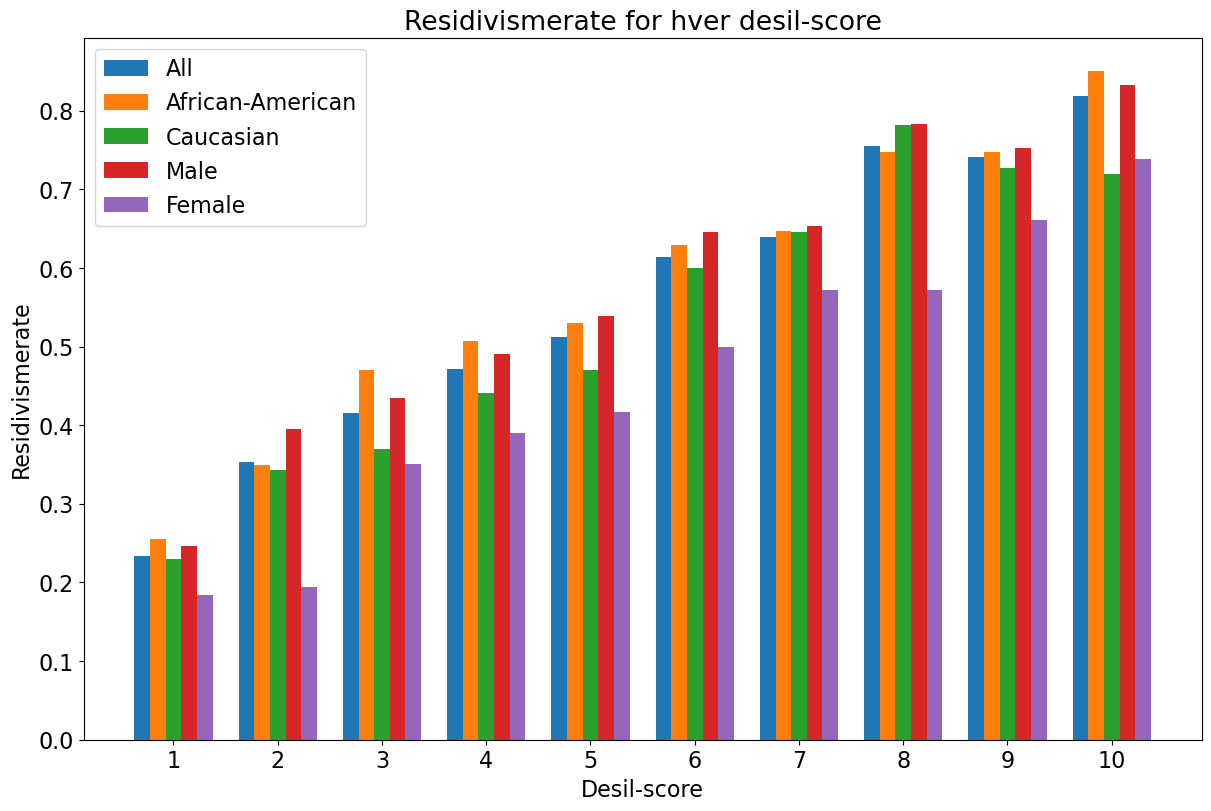

In [38]:
fig = plt.figure(figsize=(12, 8), layout="constrained")
ax = plt.axes()
fig.add_axes(ax)
# fig, ax = plt.subplots(layout="constrained")

x = np.arange(len(deciles["All"]))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

for k, v in deciles.items():
    offset = width*multiplier
    rects = ax.bar(x + offset, v, width, label=k)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Residivismerate")
ax.set_title("Residivismerate for hver desil-score")
ax.set_xlabel("Desil-score")
ax.set_xticks(x + 2*width, x+1)
ax.legend()